# Cotton Leaf Disease Prediction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [57]:
# Required modules

import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from zipfile import ZipFile
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 7)

In [58]:
# Dividing into train and validation split

img_h = 300
img_w = 300

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255.,
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.2
)

train = datagen.flow_from_directory(
    r"C:\Users\super\OneDrive\Desktop\semester 3\ML project\Cotton-Leaf-Disease-Detection-main\Cotton Disease Dataset\train",
    seed = 88,
    subset = 'training',
#     target_size = (img_h, img_w),
    batch_size = 32
)

valid = datagen.flow_from_directory(
    r"C:\Users\super\OneDrive\Desktop\semester 3\ML project\Cotton-Leaf-Disease-Detection-main\Cotton Disease Dataset\val",
    seed = 88,
    subset = 'validation',
#     target_size = (img_h, img_w),
    batch_size = 32
)

Found 1562 images belonging to 4 classes.
Found 49 images belonging to 4 classes.


In [67]:
conv_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(input_shape=(img_h, img_w, 3), filters=32, padding='same', kernel_size=3, activation='swish'),
    tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='swish'),
    tf.keras.layers.Conv2D(filters=128, padding='same', kernel_size=3, activation='swish'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=64, padding='same', kernel_size=3, activation='swish'),
    tf.keras.layers.Conv2D(filters=64, padding='same', kernel_size=3, activation='swish'),
    tf.keras.layers.Conv2D(filters=64, padding='same', kernel_size=3, activation='swish'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='swish'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax'),
])

In [72]:
# Pre-trained model

in_layer = tf.keras.layers.Input(shape=(None, None, 3))
xception = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', input_tensor=in_layer)

for layer in xception.layers:
    layer.trainable = False

inter = tf.keras.layers.GlobalMaxPooling2D()(xception.output)
flatten = tf.keras.layers.Flatten()(inter)
dense1 = tf.keras.layers.Dense(512, activation='relu')(flatten)
dense2 = tf.keras.layers.Dense(256, activation='relu')(dense1)
dense3 = tf.keras.layers.Dense(128, activation='relu')(dense2)
output = tf.keras.layers.Dense(4, activation='softmax')(dense3)

xception = tf.keras.models.Model(inputs=xception.inputs, outputs=output)

## For the pre-trained model
https://dockship.io/notebooks/60ba40b67354863913633025/boat-type-classification-ai-challenge-peddi-anurag-notebook
https://data-science-blog.com/blog/2022/04/11/how-to-choose-the-best-pre-trained-model-for-your-convolutional-neural-network/
https://medium.com/@draj0718/image-classification-and-prediction-using-transfer-learning-3cf2c736589d

In [76]:
model = xception

In [77]:
initial_lr = 0.01


lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps=25,
    decay_rate=0.96,
    staircase=True
)

In [78]:
# Defining callbacks

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', patience=10, verbose=0)
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_weights.hdf5', monitor='val_acc', mode='max', save_weights_only=True, verbose=0)

callbacks = [checkpoint, early_stopping]


In [79]:
# Defining optimizer and loss functions

#optim = tf.keras.optimizers.RMSprop(learning_rate=lr_scheduler)
optim = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
loss_funct = 'CategoricalCrossentropy'

model.compile(optimizer=optim, loss=loss_funct, metrics=['acc'])

In [80]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_24[0][0]']               
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                         

                                                                                                  
 block4_sepconv1 (SeparableConv  (None, None, None,   188672     ['block4_sepconv1_act[0][0]']    
 2D)                            728)                                                              
                                                                                                  
 block4_sepconv1_bn (BatchNorma  (None, None, None,   2912       ['block4_sepconv1[0][0]']        
 lization)                      728)                                                              
                                                                                                  
 block4_sepconv2_act (Activatio  (None, None, None,   0          ['block4_sepconv1_bn[0][0]']     
 n)                             728)                                                              
                                                                                                  
 block4_se

 lization)                      728)                                                              
                                                                                                  
 add_100 (Add)                  (None, None, None,   0           ['block6_sepconv3_bn[0][0]',     
                                728)                              'add_99[0][0]']                 
                                                                                                  
 block7_sepconv1_act (Activatio  (None, None, None,   0          ['add_100[0][0]']                
 n)                             728)                                                              
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, None, None,   536536     ['block7_sepconv1_act[0][0]']    
 2D)                            728)                                                              
          

 block9_sepconv3_act (Activatio  (None, None, None,   0          ['block9_sepconv2_bn[0][0]']     
 n)                             728)                                                              
                                                                                                  
 block9_sepconv3 (SeparableConv  (None, None, None,   536536     ['block9_sepconv3_act[0][0]']    
 2D)                            728)                                                              
                                                                                                  
 block9_sepconv3_bn (BatchNorma  (None, None, None,   2912       ['block9_sepconv3[0][0]']        
 lization)                      728)                                                              
                                                                                                  
 add_103 (Add)                  (None, None, None,   0           ['block9_sepconv3_bn[0][0]',     
          

                                                                                                  
 block12_sepconv2 (SeparableCon  (None, None, None,   536536     ['block12_sepconv2_act[0][0]']   
 v2D)                           728)                                                              
                                                                                                  
 block12_sepconv2_bn (BatchNorm  (None, None, None,   2912       ['block12_sepconv2[0][0]']       
 alization)                     728)                                                              
                                                                                                  
 block12_sepconv3_act (Activati  (None, None, None,   0          ['block12_sepconv2_bn[0][0]']    
 on)                            728)                                                              
                                                                                                  
 block12_s

In [81]:
# Fitting on the training data

epochs = 20
batch_size = 64

history = model.fit(train, validation_data=valid, epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Epoch 1/20
49/49 [==============================] - 450s 9s/step - loss: 4.2694 - acc: 0.5512 - val_loss: 0.4896 - val_acc: 0.7755
Epoch 2/20
49/49 [==============================] - 457s 9s/step - loss: 0.4270 - acc: 0.8496 - val_loss: 0.5758 - val_acc: 0.7755
Epoch 3/20
49/49 [==============================] - 486s 10s/step - loss: 0.3198 - acc: 0.8969 - val_loss: 0.3001 - val_acc: 0.8776
Epoch 4/20
49/49 [==============================] - 429s 9s/step - loss: 0.2123 - acc: 0.9309 - val_loss: 0.1546 - val_acc: 0.9388
Epoch 5/20
49/49 [==============================] - 441s 9s/step - loss: 0.2410 - acc: 0.9238 - val_loss: 0.1955 - val_acc: 0.9388
Epoch 6/20
49/49 [==============================] - 435s 9s/step - loss: 0.1695 - acc: 0.9449 - val_loss: 0.1485 - val_acc: 0.9388
Epoch 7/20
49/49 [==============================] - 467s 10s/step - loss: 0.1447 - acc: 0.9507 - val_loss: 0.2365 - val_acc: 0.9184
Epoch 8/20
49/49 [==============================] - 425s 9s/step - loss: 0.1555 -

In [82]:
tf.keras.models.save_model(model,'model_xception.hdf5')

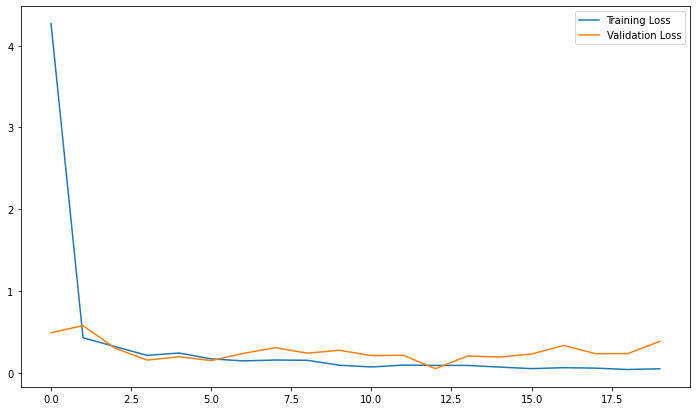

In [83]:
# Plotting Loss

plt.plot(history.epoch, history.history['loss'], label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
plt.legend()

In [90]:
print(history.history['acc'][19])
print(history.history['val_acc'][19])

0.9833546876907349
0.8979591727256775


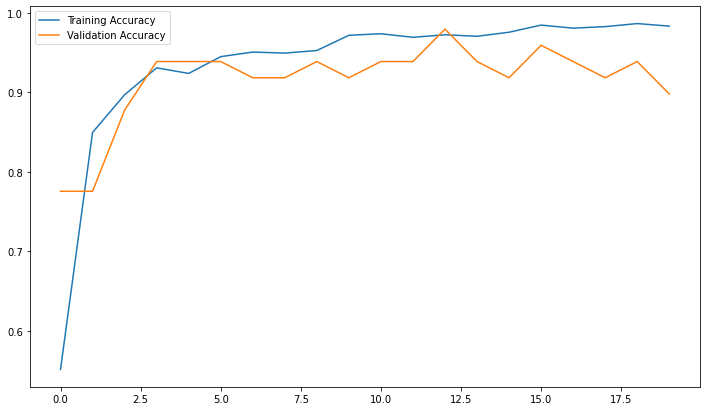

In [84]:
# Plotting Accuracy

x_axis = range(epochs)

plt.plot(history.epoch, history.history['acc'], label='Training Accuracy')
plt.plot(history.epoch, history.history['val_acc'], label='Validation Accuracy')
plt.legend()

In [85]:
# Loading the best model

model.load_weights('model_weights.hdf5')